#QUINCY HERSHEY - ALEX MOORE - ADAM DICHIARA - SCOTT TANG - VINCENT FILARDI
#CS541 Project: MAML CNN
---


In [1]:
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

dir = 'data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
np.random.seed(1)
random.seed(1)

data = np.load(dir+'RESISC45_images_256.npy')
labels = np.load(dir+'RESISC45_classes.npy')

test_size = 0.8
img_size = 256
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size = test_size, stratify = labels)


np.save(dir+'RESISC45_images_train.npy', xtrain)
np.save(dir+'RESISC45_labels_train.npy', ytrain)
np.save(dir+'RESISC45_images_test.npy', xtest)
np.save(dir+'RESISC45_labels_test.npy', ytest)

In [3]:
train_data = np.load(dir+'RESISC45_images_train.npy')
train_labels = np.load(dir+'RESISC45_labels_train.npy')
classes = np.load(dir+'RESISC45_class_names.npy')

print('Training data shape: ', train_data.shape)
print('Testing data shape: ', train_labels.shape)
print('Num Classes', classes.shape)

Training data shape:  (6300, 256, 256, 3)
Testing data shape:  (6300,)
Num Classes (45,)


In [4]:
img_size = train_data.shape[2]# can use this to modify data size to fit this model (which only takes 256 images)

bs = 32 #MAKE IT power of 2

c_dim = classes.shape[0]

print(img_size)

256


In [5]:
class CustomTensorDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform=transform

    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.images)

In [6]:
xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = test_size)

xtrain = torch.tensor(xtrain).permute(0,3,1,2)
ytrain = torch.tensor(ytrain)
print(torch.min(xtrain), torch.max(xtrain))

trainset = CustomTensorDataset(xtrain, ytrain)
    
train_loader = DataLoader(trainset, batch_size=int(bs*2), shuffle=True) #BUG: must keep shuffle false - or else it screws up labels, apparently

## Validation Data
valset = []
xval = torch.tensor(xval).permute(0,3,1,2)
yval = torch.tensor(yval)

print(torch.min(xval), torch.max(xval))

valset = CustomTensorDataset(xval, yval)

val_loader = torch.utils.data.DataLoader(valset, batch_size=64, drop_last = True, shuffle=True) #BUG: must keep shuffle false - or else it screws up labels, apparently

## Testing Data
test_data = np.load(dir+'RESISC45_images_test.npy')
test_labels = np.load(dir+'RESISC45_labels_test.npy')

print(test_data.shape)
xtest = torch.tensor(test_data).permute(0,3,1,2)
ytest = torch.tensor(test_labels)
print(xtest.shape)

print(torch.min(xtest), torch.max(xtest))

testset = CustomTensorDataset(xtest, ytest)

test_loader = torch.utils.data.DataLoader(testset, batch_size=64, drop_last = True, shuffle=True) #BUG: must keep shuffle false - or else it screws up labels, apparently

tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
(25200, 256, 256, 3)
torch.Size([25200, 3, 256, 256])
tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


Shape of a batch of images:
torch.Size([64, 3, 256, 256])
Shape of a batch of labels:
torch.Size([64])
2
torch.Size([3, 256, 256])
tensor(3, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
tensor(40, dtype=torch.int32)
storage_tank


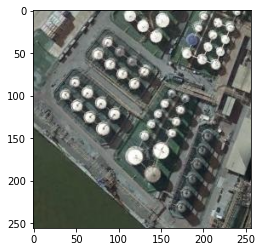

In [7]:
print('Shape of a batch of images:')
print(next(iter(train_loader))[0].shape)
print('Shape of a batch of labels:')
print(next(iter(train_loader))[1].shape)

first_samp = next(iter(train_loader)) #get first sample in first batch

print(len(first_samp))

first_im = first_samp[0][0]
print(first_im.shape)
print(torch.min(first_im), torch.max(first_im)) #images naturally (0,255)
plt.imshow(first_im.permute(1,2,0)/255) #show it

name = first_samp[1][0]
print(name)
print(classes[name]) 

In [8]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        ## Encoding: Unconditional samples
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (bs, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        #self.conv7 = nn.Conv2d(2048, z_dim, 4, 2, 0) # Output: (bs, c_dim, 1, 1)
        self.fce = nn.Linear(1024*4*4, 45)

    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        # Encode data x to 2 spaces: condition space and variance-space
        x = x/127.5 - 1
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        
        #print(x.shape, self.fce.weight.shape)
        x = x.view(x.shape[0], -1)

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        #m.bias.data.zero_()

def one_hot_embedding(labels):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
    return torch.squeeze(labels)

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [9]:
CNN = Conv_Pred()
CNN.weight_init()
CNN.to(device)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
learning_rate = 0.0006
learning_rate1 = 0.0006

CNN_optimizer = optim.Adam(CNN.parameters(),
                         lr = learning_rate)
                         #betas = (beta_1, beta_2))

In [10]:
#augmentation_functions.py

class addGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)
        self.p = p
      
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn(img.size(), device = device) * self.std + self.mean
        return img
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)

def applyAugs(img_batch, task_idx, num_augs=7):
    # returns augmented batch of images based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(0.8, 1.0)),
                                                   #interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)
    img_batch = transform(img_batch)
    #print(img_batch.shape)
    return img_batch

def getAugmentationTransforms(task_idx, num_augs=7):
    # returns transforms.Compose function of transforms based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(1.0, 1.0),
                                                   interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)

    return transform

# utility functions
# images must be normalized and converted to torch shape before augmentations (3,h,w)
# converted to numpy shape for displaying (h,w,3)

def normalizeImages(x):
  x = x/255.
  return x

def convertToTorch(x):
  x = np.moveaxis(x, 3, 1)
  x = torch.as_tensor(x)
  return x

def convertToNumpy(x):
  # convert back to format for displaying
  x = x.numpy()
  x = np.moveaxis(x, 1, 3)  
  return x

In [11]:
epoch_tracker = []
CNN_loss_tracker = []
val_accs, val_topks = [], []
i = 0
tasks = 128
n_epochs = 300 # 25+ needed. just keep raising this number...
print_stride = n_epochs // 10
for epoch in range(1, n_epochs+1):

    CNN_losses = []


    for X, y in train_loader:       #you could bump in here and do for i in range(128)

        y = one_hot_embedding(y.to(device)).float()
        #print('X', X.shape)

        X1 = X[:int(X.shape[0]/2)].float().clone().to(device)
        X2 = X[int(X.shape[0]/2):].float().clone().to(device)
        y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
        y2 = y[int(y.shape[0]/2):].float().clone().to(device)

        mini_batch = X1.size()[0]
        #X= X.to(device).float()

        task_batch1 = applyAugs(X1, int(i%tasks)).to(device)
        task_batch2 = applyAugs(X2, int(i%tasks)).to(device)
        i += 1
        
        #print(task_batch1.shape)
        #print(task_batch2.shape)

        CNN1 = copy.deepcopy(CNN).to(device)
        CNN1_optimizer = optim.Adam(CNN1.parameters(), lr = learning_rate1)

        ## CNN Training
        for param in CNN.parameters(): param.grad = None
        for param in CNN1.parameters(): param.grad = None

        yhat = CNN1(task_batch1)
        pred_loss = bce_loss(yhat, y1)
        pred_loss.backward()

        CNN1_optimizer.step()

        CNN_losses += [pred_loss.item()]
        for param in CNN.parameters(): param.grad = None
        for param in CNN1.parameters(): param.grad = None

        yhat = CNN1(task_batch2)
        pred_loss = bce_loss(yhat, y2)
        pred_loss.backward()

        for net1, net2 in zip(CNN.named_parameters(), CNN1.named_parameters()):
            net1[1].grad = net2[1].grad.clone()

        CNN_optimizer.step()

        CNN_losses += [pred_loss.item()]
        
    
    if epoch % print_stride == 0:
        print('Epoch {} - loss_CNN: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(CNN_losses))))

        CNN_loss_tracker.append(torch.mean(torch.FloatTensor(CNN_losses)))
        
        with torch.no_grad():
            accs, actk = [], []
            for x, y in val_loader:
                x, y = x.to(device).float(), y.to(device).float()
                #print(x, y)
                yhat = CNN(x)
                
                yhat_max = torch.max(yhat, dim = 1)[1]
                #print(yhat.shape)
                
                correct = torch.sum(yhat_max == y)
                size = x.shape[0]
                
                acc_topk = accuracy_topk(yhat, y)
                #print(acc_topk)
                actk.append(acc_topk.data.item())
                
                accs.append(100*(correct/size).data.item())

            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
            print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
            
        val_accs.append(torch.mean(torch.FloatTensor(accs)))
        val_topks.append(torch.mean(torch.FloatTensor(actk)))
        epoch_tracker.append(epoch)

<ipython-input-8-09971d554269>:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = c_dim)
C:\conda\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Epoch 30 - loss_CNN: 2.725
Validation Accuracy:  3.7059295177459717
Validation Top3 Accuracy:  6.67067289352417
Epoch 60 - loss_CNN: 4.256
Validation Accuracy:  2.0833332538604736
Validation Top3 Accuracy:  6.790865421295166


KeyboardInterrupt: 

In [ ]:
plt.plot(epoch_tracker, CNN_loss_tracker, label = 'train loss')
plt.plot(epoch_tracker, val_accs, label = 'val acc')
plt.plot(epoch_tracker, val_topks, label = 'val top3')
plt.legend(loc = 'best')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(epoch_tracker, CNN_loss_tracker, label = 'train loss')
ax1.legend(loc = 'best')
ax2.plot(epoch_tracker, val_accs, label = 'val acc')
ax2.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
with torch.no_grad():
    accs, topks = [], []
    for x, y in test_loader:
        x, y = x.to(device).float(), y.to(device).float()
        #print(x, y)
        yhat = CNN(x)

        yhat_max = torch.max(yhat, dim = 1)[1]
        #print(yhat.shape)

        correct = torch.sum(yhat_max == y)
        size = x.shape[0]
        acc_topk = accuracy_topk(yhat, y)
        actk.append(acc_topk.data.item())
                
        accs.append(100*(correct/size).data.item())
        topks.append(actk)

    print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
    print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())

## Scrap Work Area 

---

In [ ]:
#GRAD DIAGNOSTICS
'''
print("PARAMS YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA == pB).all())
print("GRAD YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA.grad == pB.grad))
'''